## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

Author - _Adrish Maity_

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe #- import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
env = TicTacToe()

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [6]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(min_epsilon, max_epsilon, decay_rate, state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
    
    
    if z > epsilon:
        inter_state = Q_state(state)
        #Exploitation: this gets the action corresponding to max q-value of current state
        action = max(Q_dict[inter_state],key=Q_dict[inter_state].get)   
    
    else:
        possible_moves = [i for i in env.action_space(state)[0]]      
        #Exploration: randomly choosing and action  
        action = possible_moves[np.random.choice(range(len(possible_moves)))]    
    
    return action 



#### Tracking the state-action pairs for checking convergence - write your code here

In [7]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
# print(len(Q_dict))
# print(len(States_track))

In [8]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values =  [
        ('x-x-x-x-x-x-x-x-x',(1,1)),
        ('x-x-x-x-x-x-x-x-x',(8,3)),
        ('x-4-x-x-x-1-x-x-x',(4,9)),
        ('x-8-5-x-x-x-x-x-x',(5,1))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
  

In [9]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [11]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [12]:
#Defining parameters for the experiment

EPISODES =  5000000         # No of Episode - 5 million Episodes
LR = 0.001                   # Learning rate
GAMMA = 0.95                 # Discount factor

max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.0001        # epsilon decay rate
threshold = 100            
policy_threshold = 1000000  

### Q-update loop ---write your code here

In [13]:
# to track progress of the learning
from tqdm import trange

In [14]:
start_time = time.time()

deltas = [] 
agent_wins = 0
env_wins = 0
draw = 0
value = "Win : {0}, Loss : {1}, Tie : {2}".format(agent_wins, env_wins, draw)

t_range = trange(EPISODES, desc=value, leave=True)

for episode in t_range:
    ##### Start writing your code from the next line

    env = TicTacToe()
    curr_state = env.state
    add_to_dict(curr_state)
    terminal_t_f = False
    reward = None
    total_reward = 0

    while terminal_t_f != True: 

        curr_state_string = Q_state(curr_state)
        curr_action = epsilon_greedy(min_epsilon, max_epsilon, decay_rate, curr_state, episode)
        next_state, reward, terminal_t_f = env.step(curr_state, curr_action)

        next_state_string = Q_state(next_state)
        add_to_dict(next_state)

        if terminal_t_f != True:
            # UPDATE RULE
            # this gets the action corresponding to max q-value of next state
            max_next =  max(Q_dict[next_state_string],key=Q_dict[next_state_string].get)   
            Q_dict[curr_state_string][curr_action] += LR * ((reward + (GAMMA*(Q_dict[curr_state_string][max_next]))) - Q_dict[curr_state_string][curr_action] ) 
        else:
            Q_dict[curr_state_string][curr_action] += LR * ((reward - Q_dict[curr_state_string][curr_action]))

            # calculate total win/loss/tie count
            if reward == 10:
                agent_wins += 1
            elif reward == -10:
                env_wins += 1
            else:
                draw += 1

        curr_state = next_state
        total_reward += reward
        deltas.append(max_next)
        
        
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):       
        initialise_tracking_states()
      
    #every 100 (threshold) episodes, the Q-dict - States_track will be saved
    if ((episode+1) % threshold) == 0:          
        save_tracking_states()
        save_obj(States_track,'States_tracked') 
        
    
    #SAVING POLICY
    #every 100000 (policy_threshold) episodes, the Q-dict - Policy will be saved
    if ((episode+1)% policy_threshold ) == 0:  
        save_obj(Q_dict,'Policy')   
    
    # refresh the progress bar every 500 episode
    if ((episode+1)% 500 ) == 0:
        value = "Win : {0}%, Loss : {1}%, Tie : {2}%, loss/win: {3}".format(
                                                                            np.round(100*agent_wins/(episode+1),2),
                                                                            np.round(100*env_wins/(episode+1),2),
                                                                            np.round(100*draw/(episode+1),2), 
                                                                            np.round(env_wins/(agent_wins+1),5)
                                                                            )
        t_range.set_description(value)
        t_range.refresh() # to show immediately the update

    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

Win : 52.43%, Loss : 18.36%, Tie : 29.21%, loss/win: 0.35007: 100%|██████████| 5000000/5000000 [1:05:16<00:00, 1276.62it/s]


#### Check the Q-dictionary

In [15]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -19.922897056834454,
              (0, 3): -19.922896403982634,
              (0, 5): -19.922895635024688,
              (0, 7): -19.922895786602886,
              (0, 9): -19.922897563784645,
              (1, 1): -19.922897136233253,
              (1, 3): -19.92289419579069,
              (1, 5): -19.922895469063086,
              (1, 7): -19.92289485694517,
              (1, 9): -19.92289383618358,
              (2, 1): -19.922895150832648,
              (2, 3): -19.922898147805515,
              (2, 5): -19.922895412164948,
              (2, 7): -19.922894936257933,
              (2, 9): -19.92289665997149,
              (3, 1): -19.922897080096078,
              (3, 3): -19.922896430009892,
              (3, 5): -19.92289551175739,
              (3, 7): -19.922894859804245,
              (3, 9): -19.92289379255137,
              (4, 1): -19.922897026656997,
              (4, 3): -19.92289744696029,
              (4, 5): 

In [16]:
len(Q_dict)

3147201

In [17]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
States_track['x-x-x-x-x-x-x-x-x'][(1,1)] 

[-0.00299984815095,
 -0.004000652514808672,
 -0.005002354737250878,
 -0.007008444823744341,
 -0.009021881870412366,
 -0.0110312940564241,
 -0.012035445340581917,
 -0.01404170549566419,
 -0.01704969501859855,
 -0.020058119829782155,
 -0.0240619516166446,
 -0.02506159268503562,
 -0.02706357582965238,
 -0.02706357582965238,
 -0.031068795045602778,
 -0.0320690179381917,
 -0.034070250867664145,
 -0.03607411983047372,
 -0.0400717360212801,
 -0.041077175889137944,
 -0.04508413280957053,
 -0.04807956488829744,
 -0.05206046579661119,
 -0.053054868965399085,
 -0.0560407778656539,
 -0.05703690116640617,
 -0.06102187533544117,
 -0.063017242412276,
 -0.06600075337475544,
 -0.06798829037982528,
 -0.06798829037982528,
 -0.0689874669233204,
 -0.0709813538744083,
 -0.0739778962228866,
 -0.0769684301195148,
 -0.07796619626194841,
 -0.0819534058269635,
 -0.08493891288705269,
 -0.08593365202557407,
 -0.08793246854240823,
 -0.08992441759428714,
 -0.09191904153165203,
 -0.09490863541568412,
 -0.095904787464

#### Check the states tracked for Q-values convergence
(non-evaluative)

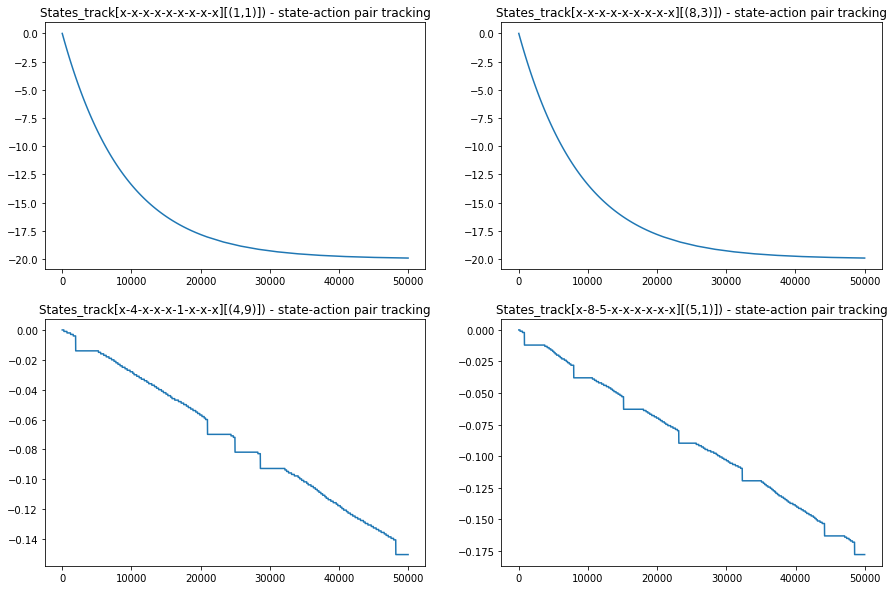

In [18]:
# Write the code for plotting the graphs for state-action pairs tracked

plt.figure(0, figsize=(15,10))

xaxis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,1)])))
plt.subplot(221)
plt.title('States_track[''x-x-x-x-x-x-x-x-x''][(1,1)]) - state-action pair tracking')
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,1)]))

xaxis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(8,3)])))
plt.subplot(222)
plt.title('States_track[''x-x-x-x-x-x-x-x-x''][(8,3)]) - state-action pair tracking')
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(8,3)]))

xaxis = np.asarray(range(0, len(States_track['x-4-x-x-x-1-x-x-x'][(4,9)])))
plt.subplot(223)
plt.title('States_track[''x-4-x-x-x-1-x-x-x''][(4,9)]) - state-action pair tracking')
plt.plot(xaxis,np.asarray(States_track['x-4-x-x-x-1-x-x-x'][(4,9)]))

xaxis = np.asarray(range(0, len(States_track['x-8-5-x-x-x-x-x-x'][(5,1)])))
plt.subplot(224)
plt.title('States_track[''x-8-5-x-x-x-x-x-x''][(5,1)]) - state-action pair tracking')
plt.plot(xaxis,np.asarray(States_track['x-8-5-x-x-x-x-x-x'][(5,1)]))

plt.show()

### Epsilon - decay check

In [19]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,50000)
epsilon = []
for i in range(0,50000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0001*i))

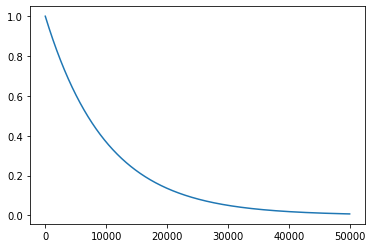

In [20]:
plt.plot(time, epsilon)
plt.show()